# Random Forest Model

In [6]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.6 MB/s eta 0:00:00a 0:00:01


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='whitegrid', palette='Set2', font_scale=1.2)

In [119]:
path='/Users/Shark/Encore/ML/titanic_challenge'
test_data = pd.read_csv('data/test.csv')
train_data = pd.read_csv('data/train.csv')

# EDA

In [4]:
print('\nNull Values in Training \n{}'.format(train_data.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_data.isnull().sum()))

print('\nDuplicated values in train {}'.format(train_data.duplicated().sum()))
print('Duplicated values in test {}'.format(test_data.duplicated().sum()))


Null Values in Training 
passengerid      0
survived         0
pclass           0
name             0
gender           0
age            180
sibsp            0
parch            0
ticket           0
fare             0
cabin          718
embarked         1
dtype: int64

Null Values in Testing 
passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

Duplicated values in train 0
Duplicated values in test 0


1. Filling Embarked and Fare

We can see we have many missing values in Age and Cabin, as we supposed before in the describing part. Most of the missing data comes from the cabin feature, this could be because not everyone had a cabin. I remember from the movie that many were stowaways and many slept together in the same cabin. There are two missing values in embarked and one in Fare. We can fill the fare with the average value of fares, that’s not a problem and fill the embarked with the most common port of embark.

In [120]:
print('Embarkation per ports \n{}'.format(train_data['embarked'].value_counts()))

# since the most common port is Southampton the chances are that the missing one is from there
train_data['embarked'].fillna(value='S', inplace=True)
test_data['fare'].fillna(value=test_data.fare.mean(), inplace=True)

print('Embarkation per ports after filling \n{}'.format(train_data['embarked'].value_counts()))

Embarkation per ports 
S    645
C    189
Q     81
Name: embarked, dtype: int64
Embarkation per ports after filling 
S    646
C    189
Q     81
Name: embarked, dtype: int64


2. Filling Age

We filled Embarked and Fare, now what can we do with Age?

To fill the age, we can check the titles (Miss, Mr, Mrs, Master, Dr) and take the age average of each one, then fill the age according to the title. Yes, Master is one of the titles used in Titanic, is used for boys and young men, mostly by english people.

Mean age of Miss. title 22.0
Mean age of Mrs. title 37.0
Mean age of Mr. title 33.0
Mean age of Master. title 5.0


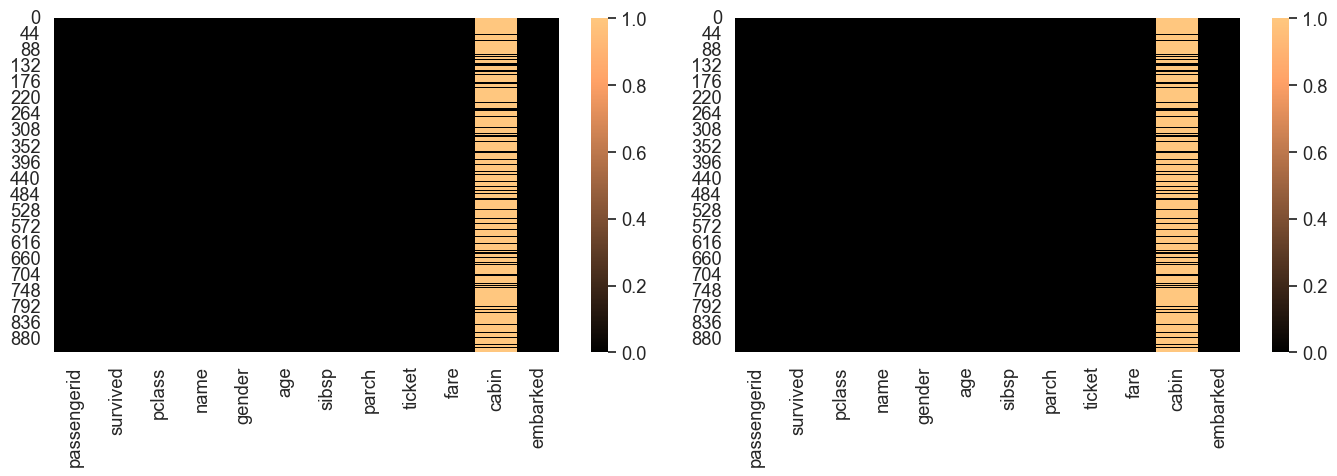

In [121]:

mean_age_miss = train_data[train_data["name"].str.contains('Miss.', na=False)]['age'].mean().round()
mean_age_mrs = train_data[train_data["name"].str.contains('Mrs.', na=False)]['age'].mean().round()
mean_age_mr = train_data[train_data["name"].str.contains('Mr.', na=False)]['age'].mean().round()
mean_age_master = train_data[train_data["name"].str.contains('Master.', na=False)]['age'].mean().round()

print('Mean age of Miss. title {}'.format(mean_age_miss))
print('Mean age of Mrs. title {}'.format(mean_age_mrs))
print('Mean age of Mr. title {}'.format(mean_age_mr))
print('Mean age of Master. title {}'.format(mean_age_master))

def fill_age(name_age):
    
    name = name_age[0]
    age = name_age[1]
    
    if pd.isnull(age):
        if 'Mr.' in name:
            return mean_age_mr
        if 'Mrs.' in name:
            return mean_age_mrs
        if 'Miss.' in name:
            return mean_age_miss
        if 'Master.' in name:
            return mean_age_master
        if 'Dr.' in name:
            return mean_age_master
        if 'Ms.' in name:
            return mean_age_miss
    else:
        return age

train_data['age'] = train_data[['name', 'age']].apply(fill_age,axis=1)
test_data['age'] = test_data[['name', 'age']].apply(fill_age,axis=1)

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,5))
sns.heatmap(train_data.isnull(),cmap='copper', ax=ax1)
sns.heatmap(train_data.isnull(), cmap='copper', ax=ax2)
plt.tight_layout()

Almost all the data from Cabin is lost, i think we could make some assumptions to figure out a way to fill it, for example, let’s keep only the first letter and fill the missing ones with X.

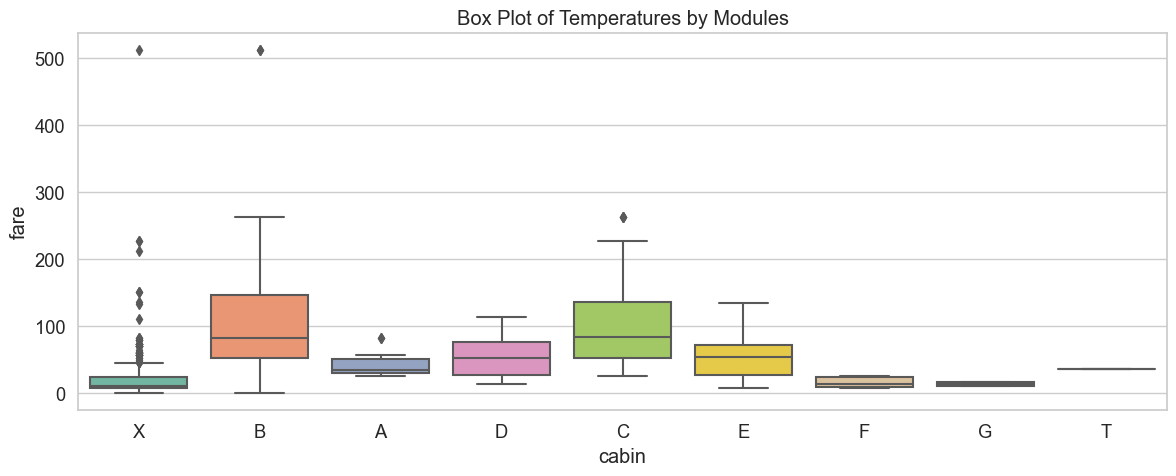

In [124]:
train_data['cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in train_data['cabin']])
test_data['cabin'] = pd.Series(['X' if pd.isnull(ii) else ii[0] for ii in test_data['cabin']])

plt.figure(figsize=(12,5))
plt.title('Box Plot of Temperatures by Modules')
sns.boxplot(x='cabin',y='fare',data=train_data, palette='Set2')
plt.tight_layout()

We can see the mean of the missing X class is very low, this means that people without a cabin assign had, in almost every case, a lower fare, but there is some outliers that we can handle. We could take those outliers and assign them to class C or B since they have a higher Fare, lets do that. I’m going to make the assumption that people without a Cabin assigned payed a low fare, so everyone with a relative high fare in class X is an outlier, therefor i will reasigna them using the mean of the rest of the classes.

Mean fare of cabin B 121.16370444444445
Mean fare of cabin C 98.04859032258065
Mean fare of cabin D 54.40195625
Mean fare of cabin E 57.774692592592594


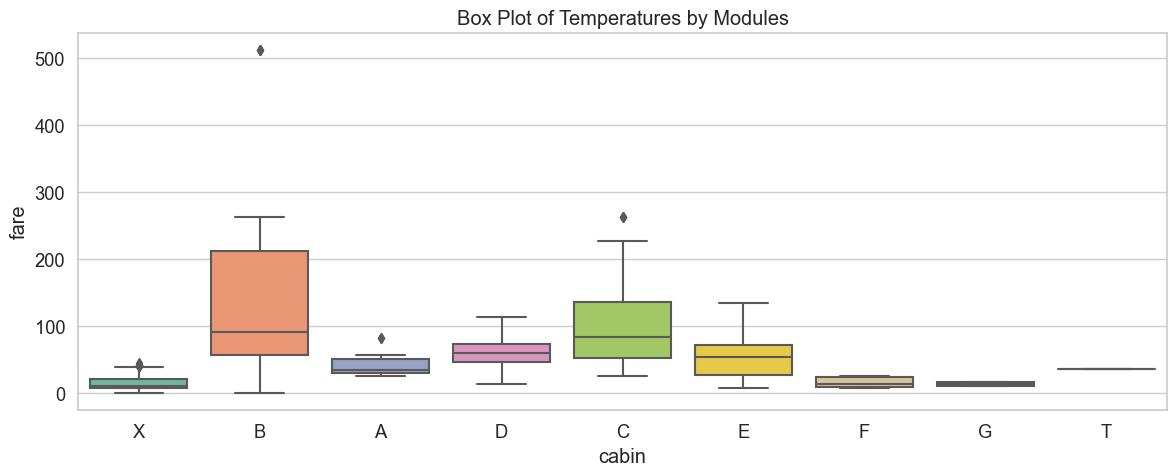

In [125]:
print('Mean fare of cabin B {}'.format(train_data[train_data['cabin']=='B']['fare'].mean()))
print('Mean fare of cabin C {}'.format(train_data[train_data['cabin']=='C']['fare'].mean()))
print('Mean fare of cabin D {}'.format(train_data[train_data['cabin']=='D']['fare'].mean()))
print('Mean fare of cabin E {}'.format(train_data[train_data['cabin']=='E']['fare'].mean()))

def reasign_cabin(cabin_fare):
    
    cabin = cabin_fare[0]
    fare = cabin_fare[1]
    
    if cabin=='X':
        if (fare >= 113.5):
            return 'B'
        if ((fare < 113.5) and (fare > 100)):
            return 'C'
        if ((fare < 100) and (fare > 57)):
            return 'D'
        if ((fare < 57) and (fare > 46)):
            return 'D'
        else:
            return 'X'
    else:
        return cabin
      
train_data['cabin'] = train_data[['cabin', 'fare']].apply(reasign_cabin, axis=1)
test_data['cabin'] = test_data[['cabin', 'fare']].apply(reasign_cabin, axis=1)

plt.figure(figsize=(12,5))
plt.title('Box Plot of Temperatures by Modules')
sns.boxplot(x='cabin',y='fare',data=train_data, palette='Set2')
plt.tight_layout()

In [126]:
train_data.isnull().sum()

passengerid    0
survived       0
pclass         0
name           0
gender         0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       0
dtype: int64

In [127]:
test_data.isnull().sum()

passengerid    0
pclass         0
name           0
gender         0
age            0
sibsp          0
parch          0
ticket         0
fare           0
cabin          0
embarked       1
dtype: int64

2. Feature Engineering

Feature engineering involves analyze the features and extract useful information out of it, also creating new features out of existing ones. Let’s start by doing some visualization.

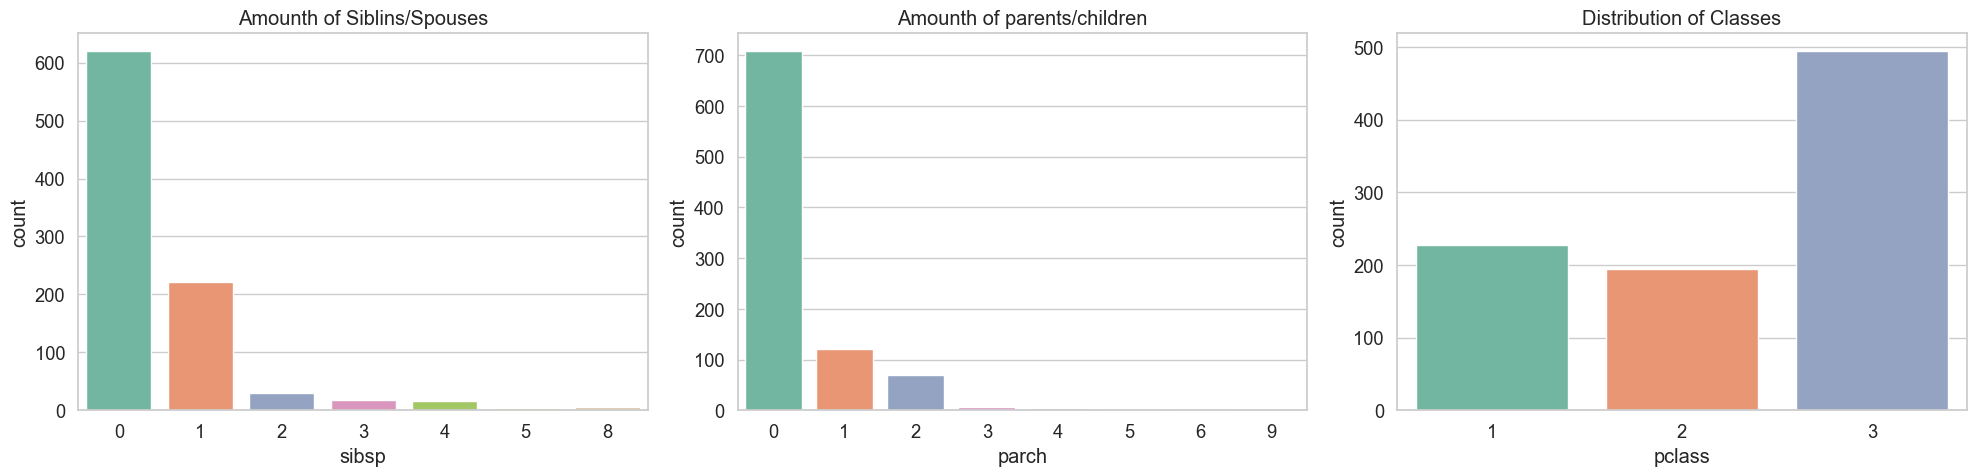

In [19]:
fig, axx = plt.subplots(1, 3, figsize=(20,5))
axx[0].set_title('Amounth of Siblins/Spouses')
sns.countplot(x='sibsp', data=train_data, ax=axx[0])
axx[1].set_title('Amounth of parents/children')
sns.countplot(x='parch', data=train_data, ax=axx[1])
axx[2].set_title('Distribution of Classes')
sns.countplot(x='pclass', data=train_data, ax=axx[2])
plt.tight_layout()

According to the graphics, we can see that most of the people were alone and most belonged to 3rd class (lower). This corresponds to what we saw earlier with the Cabins and the fare, most people without a cabin assign had a small fare, makes sense they belong to class 3. We can create a new feature that specifies if the person was traveling alone or with family based on SibSp (Siblings/Spouses) and Parch (Parents/Children) attributes, also the size of the family. Those attributes could be of interest. Also, let’s plot the data in relation to the label.

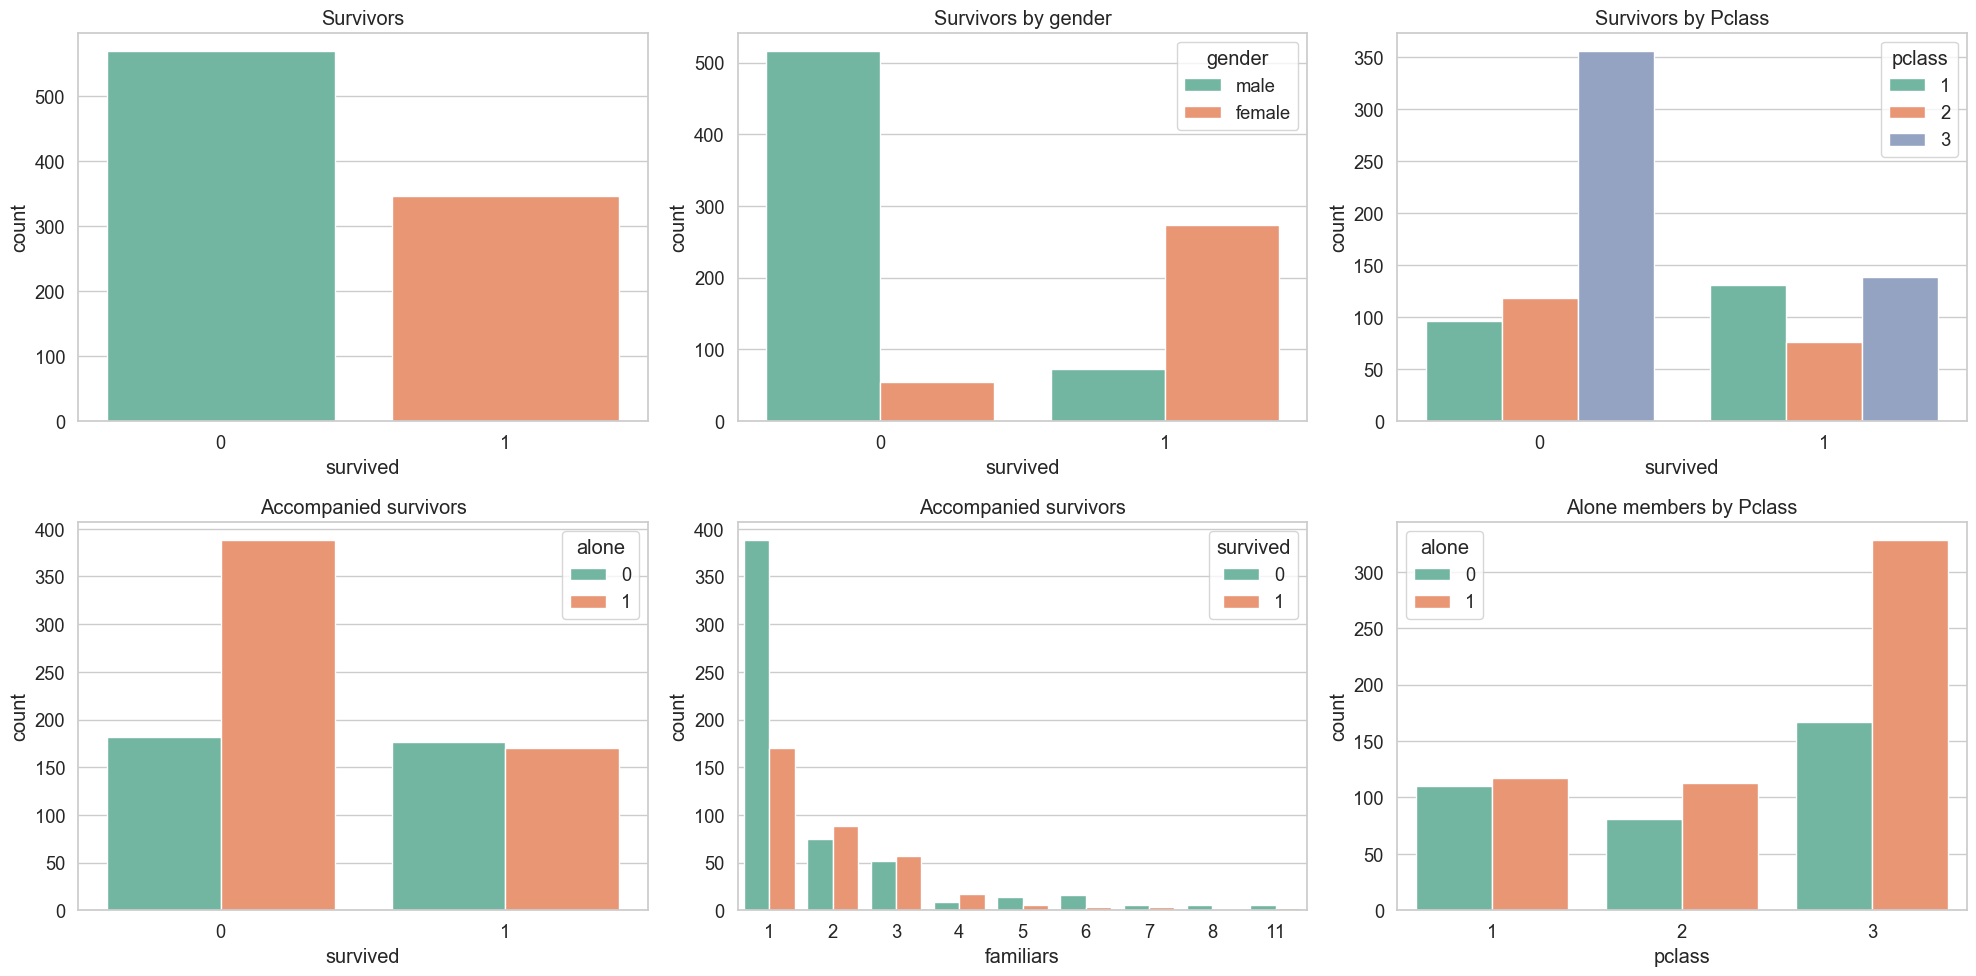

In [128]:
def create_alone_feature(sibsp_parch):
    if (sibsp_parch[0]+sibsp_parch[1])==0:
        return 1
    else:
        return 0

train_data['alone'] = train_data[['sibsp','parch']].apply(create_alone_feature, axis=1)
train_data['familiars'] = 1 + train_data['sibsp'] + train_data['parch']

test_data['alone'] = test_data[['sibsp','parch']].apply(create_alone_feature, axis=1)
test_data['familiars'] = 1 + test_data['sibsp'] + test_data['parch']

fig, axx = plt.subplots(2, 3, figsize=(20,10))
axx[0,0].set_title('Survivors')
sns.countplot(x='survived', data=train_data, ax=axx[0,0])
axx[0,1].set_title('Survivors by gender')
sns.countplot(x='survived', hue='gender', data=train_data, ax=axx[0,1])
axx[0,2].set_title('Survivors by Pclass')
sns.countplot(x='survived', hue='pclass', data=train_data, ax=axx[0,2])
axx[1,0].set_title('Accompanied survivors')
sns.countplot(x='survived', hue='alone', data=train_data, ax=axx[1,0])
axx[1,1].set_title('Accompanied survivors')
sns.countplot(x='familiars', hue='survived', data=train_data, ax=axx[1,1])
axx[1,2].set_title('Alone members by Pclass')
sns.countplot(x='pclass', hue='alone', data=train_data, ax=axx[1,2])
plt.tight_layout()

From the graphics we can see that most people died in the incident. Although most of the passengers were males, most of the survivals were woman, of course, ship workers and staff were probably males in majority, so it makes sense. We can see also that the majority of dead ones belonged to 3rd class (low class people), they were probably evacuated last and possibly were located in parts of the ship of more difficult access. Most of those who died were alone, this makes sense cause people from 3rd class were mostly alone and were the ones who died the most. Now let’s see the age and the fare of the survivors.

/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32711/3479155470.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(a=train_data[train_data['survived']==0]['fare'], ax=axx[0], bins=30)
/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32711/3479155470.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad

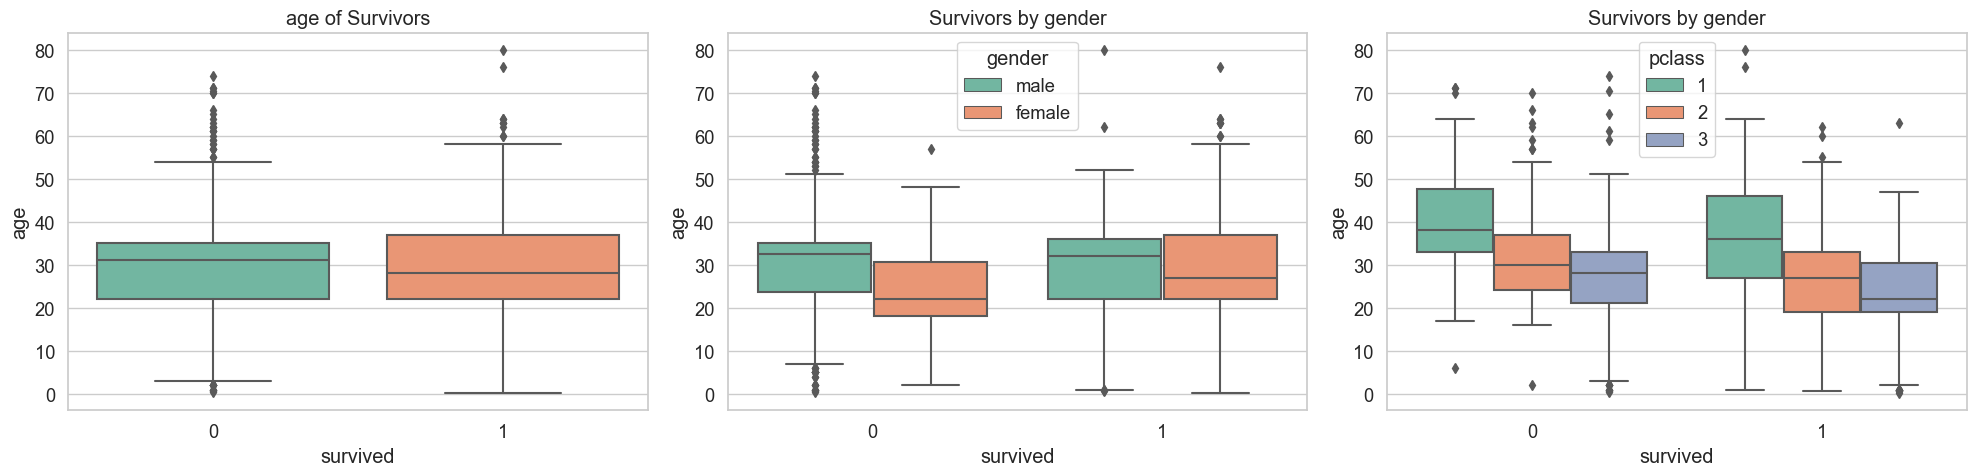

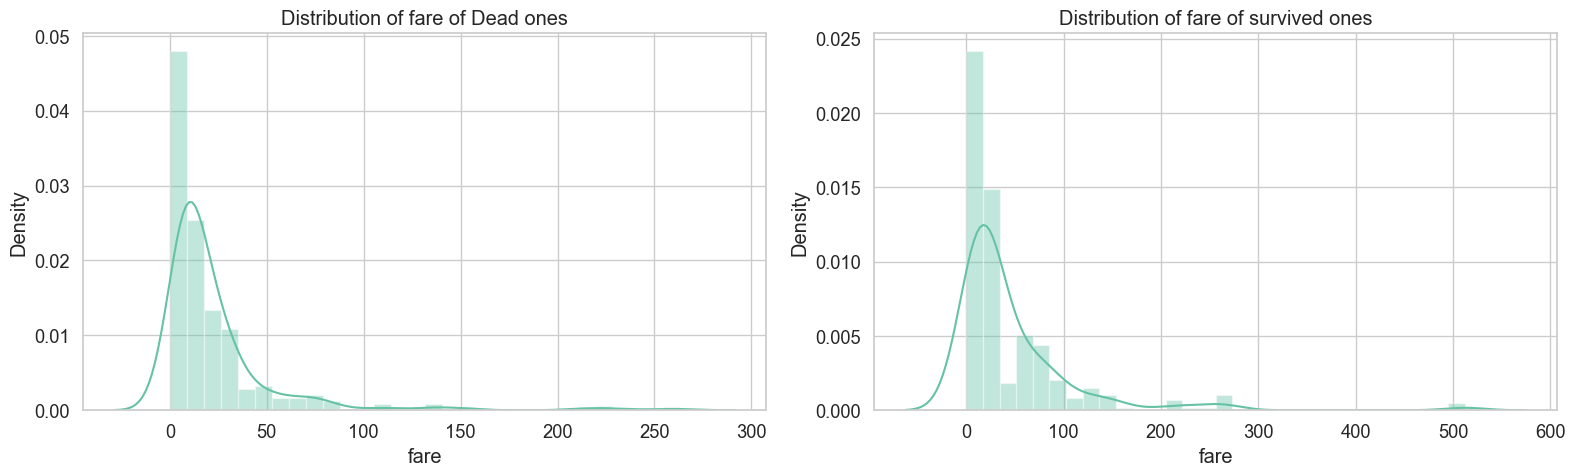

In [28]:
fig, axx = plt.subplots(1, 3, figsize=(20,5))
axx[0].set_title('age of Survivors')
sns.boxplot(x='survived', y='age', data=train_data, ax=axx[0])
axx[1].set_title('Survivors by gender')
sns.boxplot(x='survived', y='age', hue='gender', data=train_data, ax=axx[1])
axx[2].set_title('Survivors by gender')
sns.boxplot(x='survived', y='age', hue='pclass', data=train_data, ax=axx[2])
plt.tight_layout()

fig, axx = plt.subplots(1, 2, figsize=(16,5))
axx[0].set_title('Distribution of fare of Dead ones')
sns.distplot(a=train_data[train_data['survived']==0]['fare'], ax=axx[0], bins=30)
axx[1].set_title('Distribution of fare of survived ones')
sns.distplot(a=train_data[train_data['survived']==1]['fare'], ax=axx[1], bins=30)
plt.tight_layout()

Clearly the Fare of those ho survived were higher, we can see that in the distribution of each one. Those who survived where a little bit younger than those who died. We can also see that people in 1st class were older than the rest and people from 3rd class were younger. Next we can see the correlation between the features. Fare and Survived has some correlation between, but correlation doesn’t take into account categoricals, so better to map features like Sex and Embarked to numbers.

/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32711/3507652188.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True)


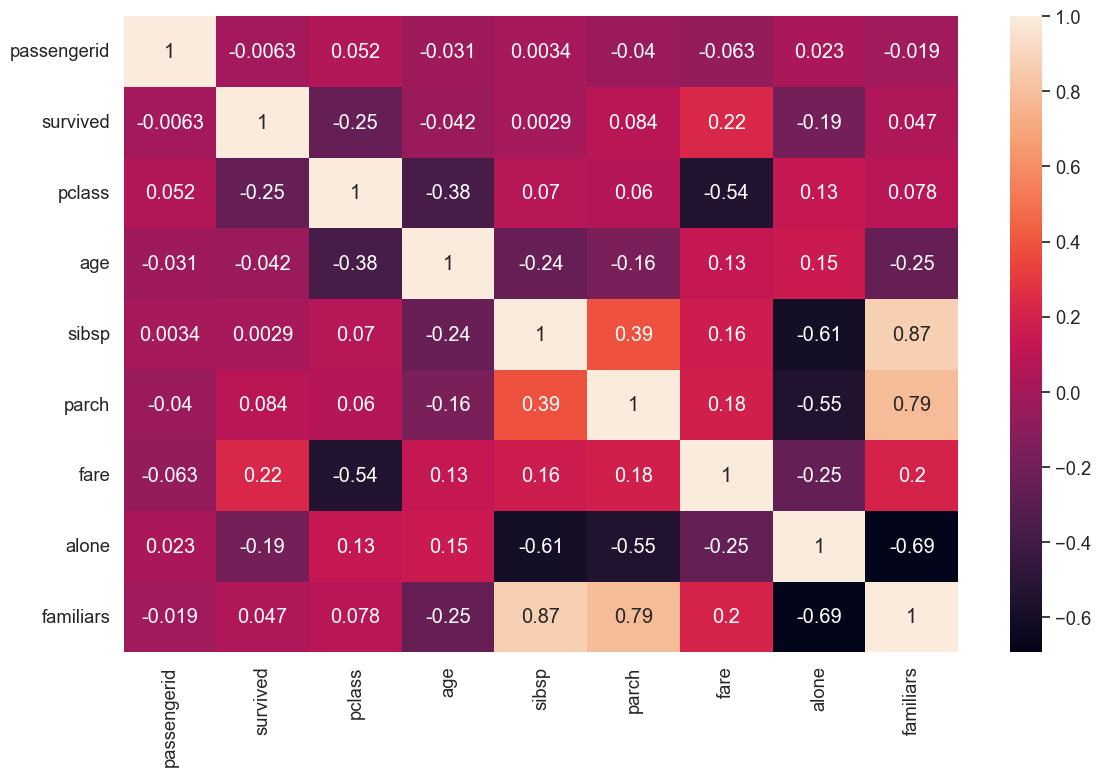

In [129]:
plt.figure(figsize=(12,8))
sns.heatmap(train_data.corr(), annot=True)
plt.tight_layout()

Machine Learning algorithms deals with numbers and not categorical, so we need to find a way to map these categories into numbers. This is easy to do in Pandas using map() method. I will define 1 for female and 0 for males, to have a positive correlation since most of the survivals were females.

/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32711/2908827417.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train_data.corr(), annot=True)


<Axes: >

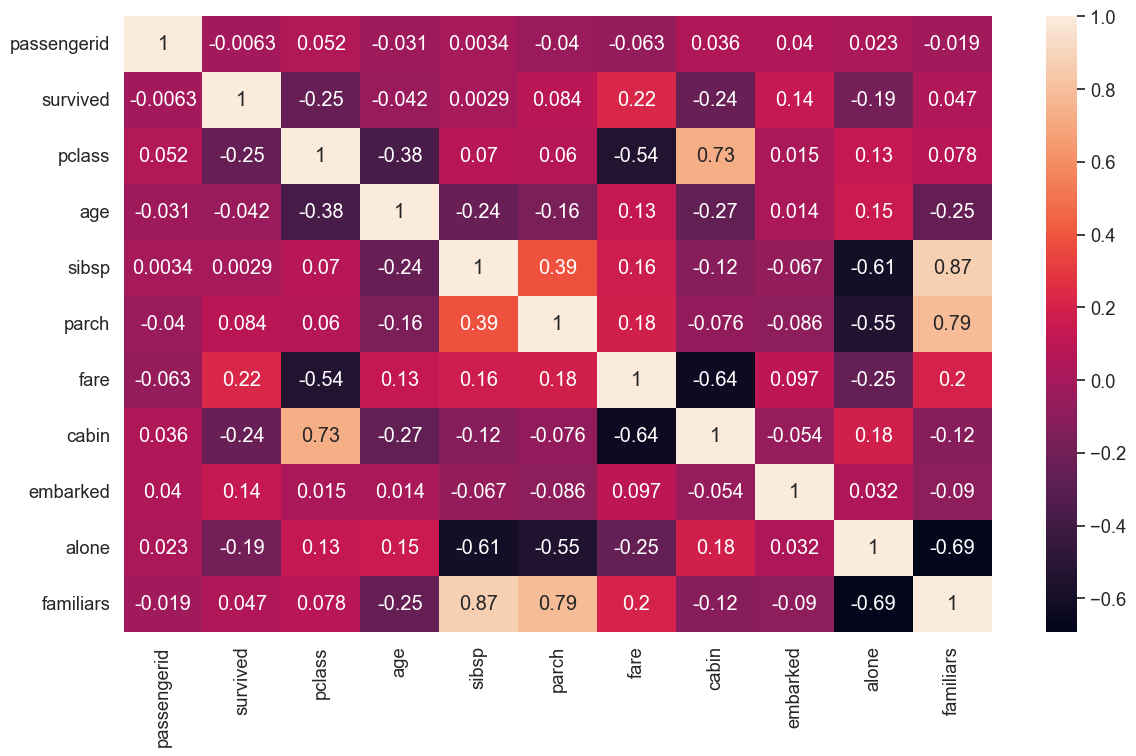

In [130]:
categories = {"female": 1, "male": 0}
#train_data['gender']= train_data['gender'].map(categories)
#test_data['gender']= test_data['gender'].map(categories)

categories = {"S": 1, "C": 2, "Q": 3}
train_data['embarked']= train_data['embarked'].map(categories)
test_data['embarked']= test_data['embarked'].map(categories)

categories = train_data.cabin.unique()
train_data['cabin'] = train_data.cabin.astype("category").cat.codes
test_data['cabin'] = test_data.cabin.astype("category").cat.codes

plt.figure(figsize=(14,8))
sns.heatmap(train_data.corr(), annot=True)

lets drop useless information such as name, ticket, passengerid.

In [131]:
train_data = train_data.drop(['name','ticket','passengerid'], axis=1)
test_data = test_data.drop(['name','ticket'], axis=1)
test_passengerid = test_data.passengerid
test_data.drop(['passengerid'], axis=1, inplace=True)
train_data.head()

,survived,pclass,gender,age,sibsp,parch,fare,cabin,embarked,alone,familiars
0,0,2,male,33.0,0,0,12.8750,8,1,1,1
1,0,3,female,22.0,0,0,7.7500,8,3,1,1
2,1,1,female,52.0,1,1,93.5000,1,1,0,3
3,1,3,male,27.0,0,0,7.7958,8,1,1,1
4,0,2,male,44.0,1,0,26.0000,8,1,0,2


In [98]:
test_data.drop(['Survival_Predictions'], axis=1, inplace=True)

In [132]:
train_data.drop(['embarked', 'alone', 'sibsp'], axis=1, inplace=True)
test_data.drop(['embarked', 'alone', 'sibsp'], axis=1, inplace=True)

In [133]:
train_data.drop(['parch'], axis=1, inplace=True)
test_data.drop(['parch'], axis=1, inplace=True)

In [134]:
gender_hot = pd.get_dummies(train_data.gender, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

train_data = pd.concat([train_data, gender_hot], axis=1)
train_data.drop(['gender'], axis=1, inplace=True)
train_data

,survived,pclass,age,fare,cabin,familiars,male
0,0,2,33.0,12.8750,8,1,1
1,0,3,22.0,7.7500,8,1,0
2,1,1,52.0,93.5000,1,3,0
3,1,3,27.0,7.7958,8,1,1
4,0,2,44.0,26.0000,8,2,1
...,...,...,...,...,...,...,...
911,0,3,33.0,6.4375,8,2,1
912,0,3,18.0,8.6625,8,1,1
913,0,2,19.0,10.5000,8,1,1
914,1,3,22.0,7.7333,8,1,0


In [135]:
gender_hot = pd.get_dummies(test_data.gender, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

test_data = pd.concat([test_data, gender_hot], axis=1)
test_data.drop(['gender'], axis=1, inplace=True)
test_data

,pclass,age,fare,cabin,familiars,male
0,3,15.0,8.0292,7,1,0
1,2,32.0,13.0000,7,1,0
2,3,22.0,7.7500,7,1,0
3,3,33.0,7.2500,7,1,1
4,1,45.0,164.8667,1,3,0
...,...,...,...,...,...,...
388,3,22.0,7.7500,7,1,0
389,1,16.0,57.9792,1,2,0
390,3,13.0,7.2292,7,1,0
391,3,39.0,31.2750,7,7,0


In [136]:
pclass_hot = pd.get_dummies(train_data.pclass, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

train_data = pd.concat([train_data, pclass_hot], axis=1)
train_data.drop(['pclass'], axis=1, inplace=True)

pclass_hot = pd.get_dummies(test_data.pclass, drop_first=True)
# drop_first=True 는 첫번째 옵션을 drop함을 뜻합니다.
# 예로 Sex column에서 female이 1이라면, 0인 row는 자동으로 male을 의미하게 됩니다.

test_data = pd.concat([test_data, pclass_hot], axis=1)
test_data.drop(['pclass'], axis=1, inplace=True)

In [137]:
train_data

,survived,age,fare,cabin,familiars,male,2,3
0,0,33.0,12.8750,8,1,1,1,0
1,0,22.0,7.7500,8,1,0,0,1
2,1,52.0,93.5000,1,3,0,0,0
3,1,27.0,7.7958,8,1,1,0,1
4,0,44.0,26.0000,8,2,1,1,0
...,...,...,...,...,...,...,...,...
911,0,33.0,6.4375,8,2,1,0,1
912,0,18.0,8.6625,8,1,1,0,1
913,0,19.0,10.5000,8,1,1,1,0
914,1,22.0,7.7333,8,1,0,0,1


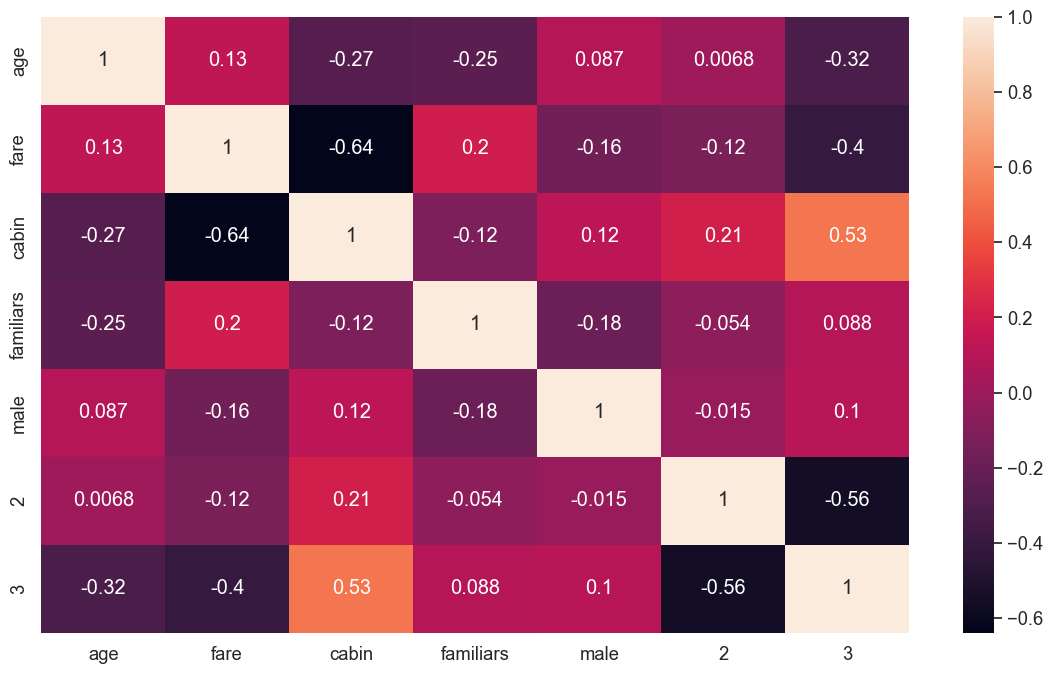

In [170]:
plt.figure(figsize=(14,8))
sns.heatmap(train_data.corr(), annot=True)
plt.show()

# Normalize the data

Many machine learning algorithms like Regression types and distance based ones can converge faster when the data is normalized, this is a key step in every machine learning situation. To do so i will use MinMaxScaler library from Scikit Learn, but first we need to drop the label. When scaling, we only fit the scaler to the training dataset.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html

In [140]:
from sklearn.preprocessing import MinMaxScaler

# Dropping label
LABEL = 'survived'
y = train_data[LABEL]
train_data = train_data.drop(LABEL, axis=1)  # Dropping label to normalize
train_data.columns = train_data.columns.astype(str)
test_data.columns = test_data.columns.astype(str)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

scaled_train = pd.DataFrame(scaled_train, columns=train_data.columns, index=train_data.index)
scaled_test = pd.DataFrame(scaled_test, columns=test_data.columns, index=test_data.index)

scaled_test.head()

,age,fare,cabin,familiars,male,2,3
0,0.185770,0.015672,0.875,0.0,0.0,0.0,1.0
1,0.398722,0.025374,0.875,0.0,0.0,1.0,0.0
2,0.273456,0.015127,0.875,0.0,0.0,0.0,1.0
3,0.411249,0.014151,0.875,0.0,1.0,0.0,1.0
4,0.561568,0.321798,0.125,0.2,0.0,0.0,0.0


# Classification

I will use Random Forest Classifier. Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. You can read more about it in here. Let’s split the data to use a testing set with labels.

https://www.datacamp.com/tutorial/random-forests-classifier-python

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.3, random_state=52, stratify=y)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

clf = RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

(641, 7) (275, 7)
(641,) (275,)


RandomForestClassifier()

An interesting thing about the Random Forest Classifier from Sklearn is that provides a very easy way of reviewing the important features for the classification.

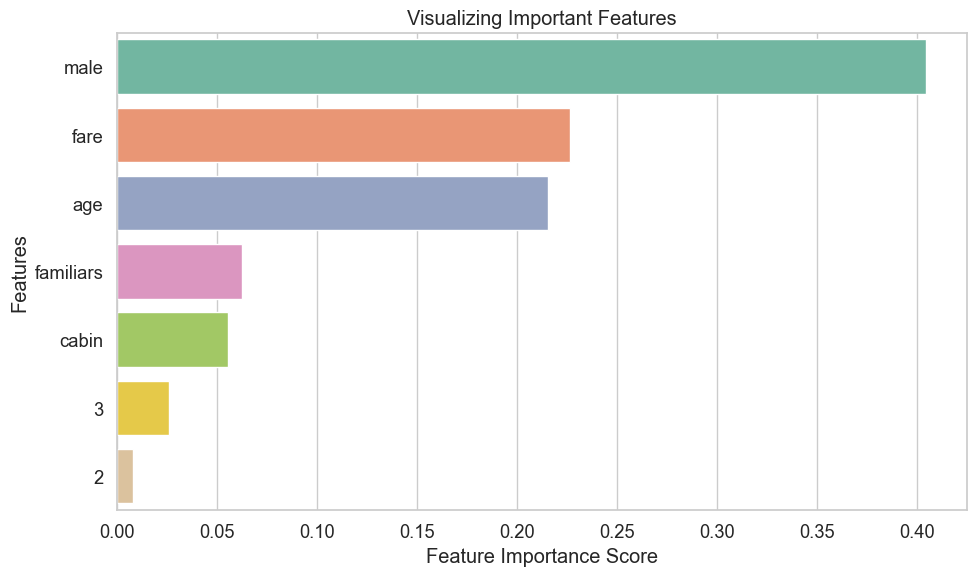

In [169]:
feature_imp = pd.Series(clf.feature_importances_, index=scaled_train.columns).sort_values(ascending=False)

#print("Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred)))

plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

We can remove the less important features for the algorithm, and see if the accuracy improves. With all the features the accuracy was 82%. Let’s see removing the less important ones like ‘Alone’, ‘Parch’ and ‘Embarked’.

# Hyperparameter Turning

Wow, that is quite an overwhelming list! How do we know where to start? A good place is the documentation on the random forest in Scikit-Learn. This tells us the most important settings are the number of trees in the forest (n_estimators) and the number of features considered for splitting at each leaf node (max_features). We could go read the research papers on the random forest and try to theorize the best hyperparameters, but a more efficient use of our time is just to try out a wide range of values and see what works! We will try adjusting the following set of hyperparameters:

n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node
bootstrap = method for sampling data points (with or without replacement)

In [143]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

Random Search Training
Now, we instantiate the random search and fit it like any Scikit-Learn model:

In [144]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [145]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.3, random_state=777, stratify=y)

rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 300, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   2.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=800; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.3s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time=   0.5s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimato

/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=300,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [146]:
import gc
gc.collect()

15694

In [147]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [56]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.1707 degrees.
Accuracy = -inf%.
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1800; total time=   2.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   2.9s
[CV] END bootstrap=True, max_depth=70, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time=   1.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estim

/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feature

[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2000; total time=   2.1s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   0.6s
[CV] END bootstrap=False, max_d

s=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_fe

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.4s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.3s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1600; total time=   1.9s
[CV] END bootstrap=False, max_depth=40, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1400; total time=   2.0s
[CV] END bootstrap=True, max_depth=7

/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feature

[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   0.7s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1000; total time=   1.5s
[CV] END bootstrap=False, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time=   1.6s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   1.3s
[CV] END bootstrap=True, max_depth=110, m

/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feature

[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time=   2.1s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1200; total time=   1.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=600; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=   2.4s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1400; total time=   1.4s
[CV] END bootstrap=False, max_depth=20,

/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/Shark/opt/anaconda3/envs/torch-gpu/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_feature

In [86]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [88]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Fitting 3 folds for each of 288 candidates, totalling 864 fits
Model Performance
Average Error: 0.2218 degrees.
Accuracy = -inf%.
Improvement of nan%.


/var/folders/5l/zhxf24nx12x4g17npl9y29700000gn/T/ipykernel_32711/2936292971.py:5: RuntimeWarning: invalid value encountered in scalar subtract
  print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))


[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   1.0s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.9s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300; total time=   0.3s
[CV] END bootstrap=True, max_depth=80, max_features=2, min_samp

In [60]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.2112 degrees.
Accuracy = -inf%.


   Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       171
           1       0.85      0.85      0.85       104

    accuracy                           0.89       275
   macro avg       0.88      0.88      0.88       275
weighted avg       0.89      0.89      0.89       275



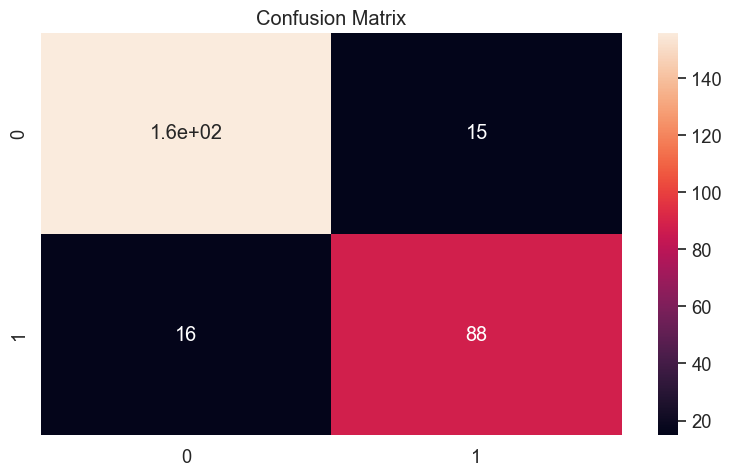

In [165]:
# Removing less important features
#new_train = scaled_train.drop(['alone','parch','embarked'], axis=1)
#new_test = scaled_test.drop(['alone','parch','embarked'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(scaled_train, y, test_size=0.3, random_state=41, stratify=y)
clf = RandomForestClassifier()

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("   Accuracy: {}".format(metrics.accuracy_score(y_test, y_pred).round(2)))

print(classification_report(y_test,y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.tight_layout()

#prediction = clf.predict(new_test)

In [72]:
new_scaled_test = scaled_test.drop(['parch', 'alone', 'embarked'], axis=1)

In [166]:
survived = clf.predict(scaled_test)

In [167]:
len(survived)

393

In [168]:
submission = pd.DataFrame({'passengerid': test_passengerid, 'Survived': survived})
submission.to_csv('data/submission_randomforest.csv', index=False)